SOURCE : [URL](https://www.kaggle.com/karnikakapoor/rain-prediction-ann/notebook)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics importconfusion_matrix

from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras import callbacks

from tensorflow.keras.optimizers import Adam
from tensorflow import device

np.random.seed(0)

## OBJECT
- 내일 비가 올지 안올지를 예측하는 예측 모델(ANN)을 만들고자 함

In [2]:
data = pd.read_csv('./data/weatherAUS.csv') # for local
# data = pd.read_csv("drive/MyDrive/Colab Notebooks/weatherAUS.csv") # for google

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
data.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

#### check target value

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

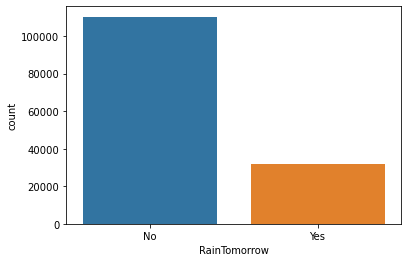

In [5]:
sns.countplot(x = data['RainTomorrow'])

<AxesSubplot:>

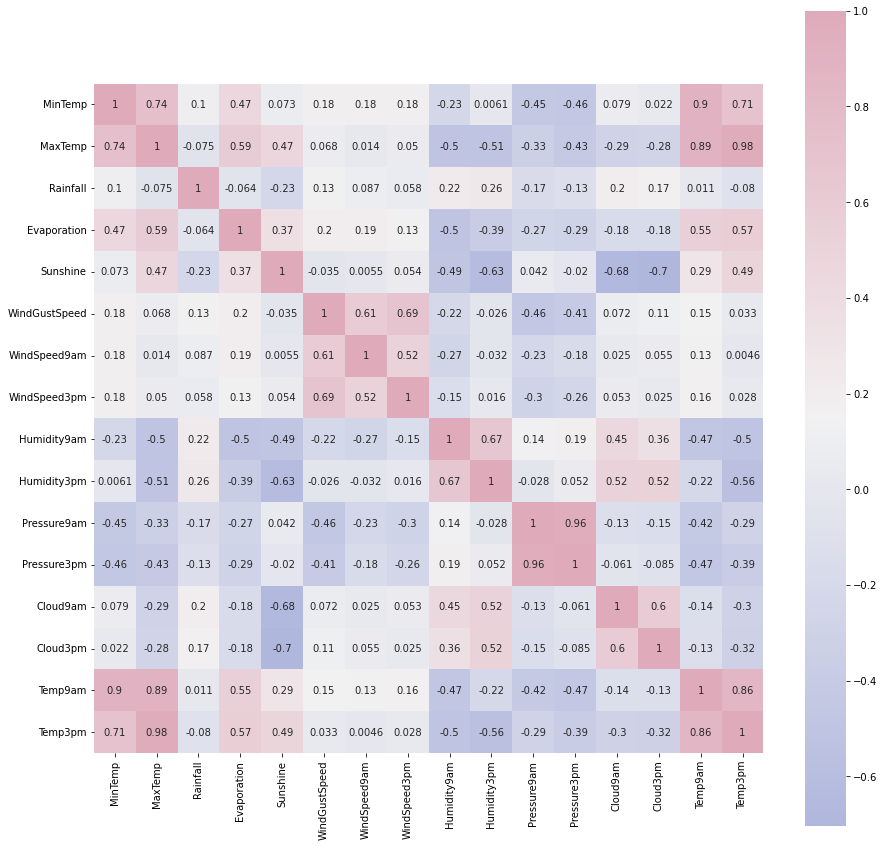

In [6]:
corrmat = data.corr()

cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True) # color map

plt.subplots(figsize=(15,15))
sns.heatmap(corrmat,cmap = cmap,annot=True,square=True)

## data cleansing
<br/>

prefer the months and days in a cyclic continuous feature. As, date and time are inherently cyclical
To let the ANN model know that a feature is cyclical I split it into periodic subsections. Namely, years, months and days

In [7]:
data['Date'].dtype

dtype('O')

In [8]:
data_c_date = data.copy()
data_c_date.loc[:,'Date'] = pd.to_datetime(data_c_date['Date'])


print(data_c_date['Date'])
print(data_c_date['Date'].isna().sum())

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
145459   2017-06-25
Name: Date, Length: 145460, dtype: datetime64[ns]
0


- add year, month, day columns

In [9]:
data_a_col = data_c_date.copy()

data_a_col['year'] = data_a_col['Date'].dt.year
data_a_col['month'] = data_a_col['Date'].dt.month
data_a_col['day'] = data_a_col['Date'].dt.day

def encode_sin_cos(df,col_n,max_val):
    df[col_n+'_sin'] = np.sin(2*np.pi*df[col_n]/max_val)
    df[col_n+'_cos'] = np.cos(2*np.pi*df[col_n]/max_val)
    
    return df

data_sin_cos = encode_sin_cos(data_a_col.copy(),'month',12)
data_sin_cos = encode_sin_cos(data_sin_cos,'day',31)

data_sin_cos[['year','month','day','month_sin','month_cos','day_sin','day_cos']]

,year,month,day,month_sin,month_cos,day_sin,day_cos
0,2008,12,1,-2.449294e-16,1.0,0.201299,0.979530
1,2008,12,2,-2.449294e-16,1.0,0.394356,0.918958
2,2008,12,3,-2.449294e-16,1.0,0.571268,0.820763
3,2008,12,4,-2.449294e-16,1.0,0.724793,0.688967
4,2008,12,5,-2.449294e-16,1.0,0.848644,0.528964
...,...,...,...,...,...,...,...
145455,2017,6,21,1.224647e-16,-1.0,-0.897805,-0.440394
145456,2017,6,22,1.224647e-16,-1.0,-0.968077,-0.250653
145457,2017,6,23,1.224647e-16,-1.0,-0.998717,-0.050649
145458,2017,6,24,1.224647e-16,-1.0,-0.988468,0.151428


- draw result

0       1
1       2
2       3
3       4
4       5
       ..
395    31
396     1
397     2
398     3
399     4
Name: day, Length: 400, dtype: int64


Text(0.5, 0, 'Days In Year')

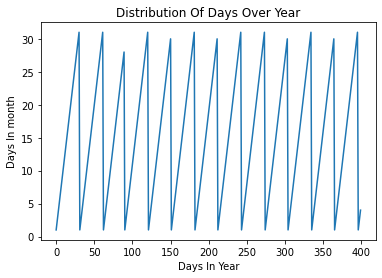

In [10]:
subset = data_sin_cos[:400] # over 365, roughly

# month - day distribution
m_d = subset['day'].plot()

m_d.set_title("Distribution Of Days Over Year")
m_d.set_ylabel("Days In month")
m_d.set_xlabel("Days In Year")

- month cyclic

Text(0.5, 0, 'Sine Encoded Months')

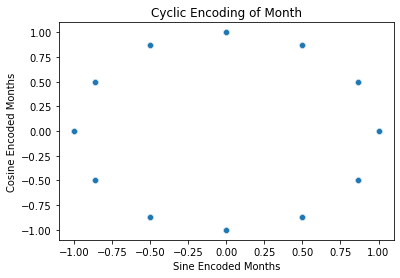

In [11]:
c_m = sns.scatterplot(x="month_sin",y="month_cos",data=data_sin_cos)

c_m.set_title("Cyclic Encoding of Month")
c_m.set_ylabel("Cosine Encoded Months")
c_m.set_xlabel("Sine Encoded Months")

- day cyclic

Text(0.5, 0, 'Sine Encoded Days')

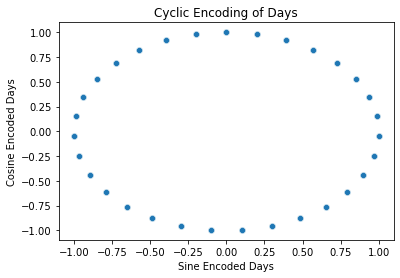

In [12]:
c_m = sns.scatterplot(x="day_sin",y="day_cos",data=data_sin_cos)

c_m.set_title("Cyclic Encoding of Days")
c_m.set_ylabel("Cosine Encoded Days")
c_m.set_xlabel("Sine Encoded Days")

### process other type cols (object, float)

In [13]:
# extract column names by type
df = data_sin_cos.copy()

s = df.dtypes == 'object'
str_cols = df.loc[:,df.dtypes == 'object'].columns
float_cols = df.loc[:,df.dtypes == 'float64'].columns

print(str_cols)
print(float_cols)

Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow'],
      dtype='object')
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos'],
      dtype='object')


In [14]:
# process na or null


# 1. str
df_c_str = df.copy()
for i in str_cols:
    df_c_str[i].fillna(df_c_str[i].mode()[0],inplace=True)
    
# 2. float
df_c_float = df_c_str.copy()
for i in float_cols:
    df_c_float[i].fillna(df_c_float[i].median(),inplace=True)

df_c_float.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [15]:
df_c_float.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
year             0
month            0
day              0
month_sin        0
month_cos        0
day_sin          0
day_cos          0
dtype: int64

# Data Preprocessing

In [16]:
# map objects to numeric
df_proc = df_c_float.copy()

label_encoder = LabelEncoder()
for i in str_cols:
    df_proc.loc[:,i] = label_encoder.fit_transform(df_proc[i]) # fit then transform, return array

In [17]:
# scaling targets
target = df_proc['RainTomorrow']
feats = df_proc.drop(['RainTomorrow','Date','day','month'],axis=1) # why excludes Date??
cols_orig = feats.columns

sd_scaler = preprocessing.StandardScaler()
feat_proc = pd.DataFrame(sd_scaler.fit_transform(feats),columns = cols_orig)

feat_proc.describe().to_json

<bound method NDFrame.to_json of            Location       MinTemp       MaxTemp      Rainfall   Evaporation  \
count  1.454600e+05  1.454600e+05  1.454600e+05  1.454600e+05  1.454600e+05   
mean  -5.633017e-14 -4.243854e-15  6.513740e-16  9.152711e-15  1.352327e-14   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -1.672228e+00 -3.250525e+00 -3.952405e+00 -2.750966e-01 -1.629472e+00   
25%   -8.991390e-01 -7.056589e-01 -7.358516e-01 -2.750966e-01 -3.711389e-01   
50%    1.451130e-02 -3.016978e-02 -8.689797e-02 -2.750966e-01 -1.194722e-01   
75%    8.578808e-01  7.238646e-01  7.031326e-01 -2.035807e-01  6.361088e-03   
max    1.701250e+00  3.410112e+00  3.510563e+00  4.394557e+01  4.398511e+01   

           Sunshine   WindGustDir  WindGustSpeed    WindDir9am    WindDir3pm  \
count  1.454600e+05  1.454600e+05   1.454600e+05  1.454600e+05  1.454600e+05   
mean  -4.338304e-15  1.864381e-14  -1.167921e-14 -7.433272e-15  1.791486e-15   
std    1.000003

### check outliers

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, 'Location'),
  Text(1, 0, 'MinTemp'),
  Text(2, 0, 'MaxTemp'),
  Text(3, 0, 'Rainfall'),
  Text(4, 0, 'Evaporation'),
  Text(5, 0, 'Sunshine'),
  Text(6, 0, 'WindGustDir'),
  Text(7, 0, 'WindGustSpeed'),
  Text(8, 0, 'WindDir9am'),
  Text(9, 0, 'WindDir3pm'),
  Text(10, 0, 'WindSpeed9am'),
  Text(11, 0, 'WindSpeed3pm'),
  Text(12, 0, 'Humidity9am'),
  Text(13, 0, 'Humidity3pm'),
  Text(14, 0, 'Pressure9am'),
  Text(15, 0, 'Pressure3pm'),
  Text(16, 0, 'Cloud9am'),
  Text(17, 0, 'Cloud3pm'),
  Text(18, 0, 'Temp9am'),
  Text(19, 0, 'Temp3pm'),
  Text(20, 0, 'RainToday'),
  Text(21, 0, 'year'),
  Text(22, 0, 'month_sin'),
  Text(23, 0, 'month_cos'),
  Text(24, 0, 'day_sin'),
  Text(25, 0, 'day_cos')])

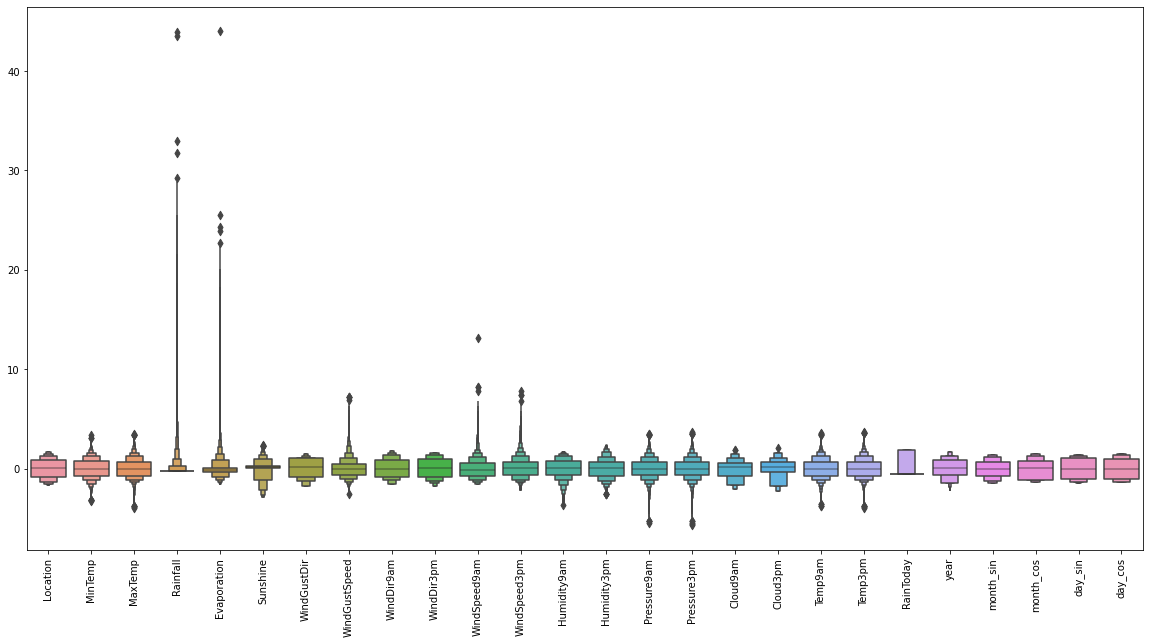

In [18]:
# boxplot
plt.figure(figsize=(20,10))
sns.boxenplot(data = feat_proc)
plt.xticks(rotation=90)

### remove outlier 
- use interquartile range (IQR) => lower acc..

In [19]:
# get IQR
Q_l = feat_proc.quantile(0.25)
Q_r = feat_proc.quantile(0.75)

iqr = Q_r-Q_l
iqr

Location         1.757020
MinTemp          1.429523
MaxTemp          1.438984
Rainfall         0.071516
Evaporation      0.377500
Sunshine         0.181305
WindGustDir      1.917303
WindGustSpeed    1.143215
WindDir9am       1.771548
WindDir3pm       1.762845
WindSpeed9am     1.354132
WindSpeed3pm     1.261948
Humidity9am      1.378923
Humidity3pm      1.367770
Pressure9am      1.233566
Pressure3pm      1.245504
Cloud9am         1.314935
Cloud3pm         0.949325
Temp9am          1.426516
Temp3pm          1.386733
RainToday        0.000000
year             1.576246
month_sin        1.417908
month_cos        1.927615
day_sin          2.031944
day_cos          2.066741
dtype: float64

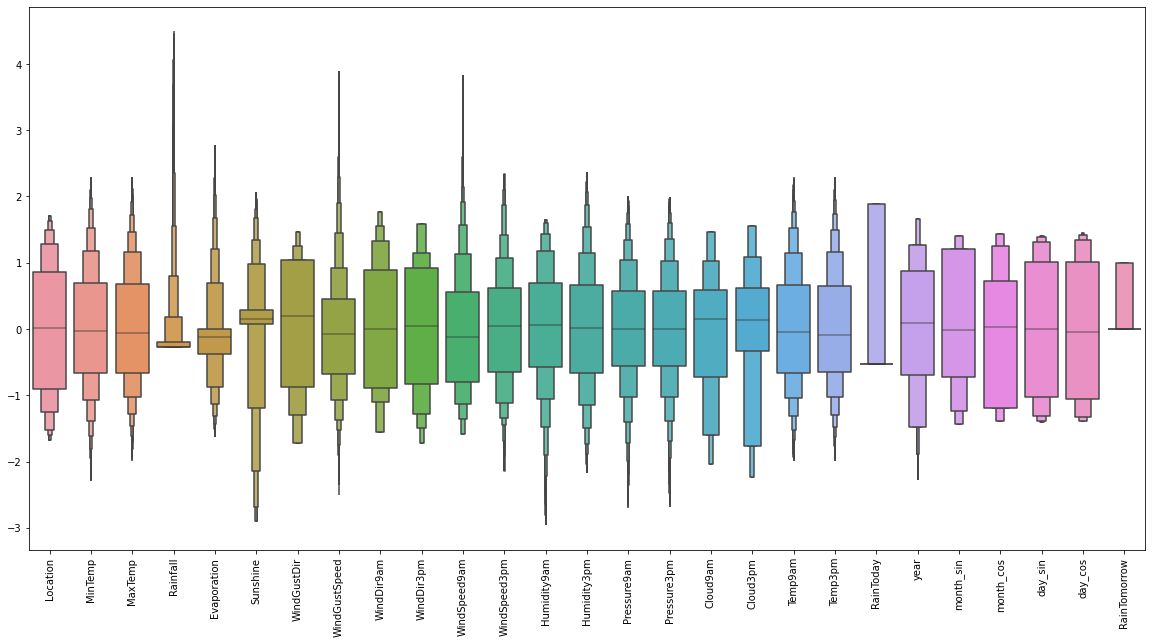

In [20]:
# cond = ~((feat_proc < Q_l - 1.5*iqr)|(feat_proc > Q_r + 1.5*iqr))
# df_iqr = feat_proc[cond]

feat_proc = feat_proc[(feat_proc["MinTemp"]<2.3)&(feat_proc["MinTemp"]>-2.3)]
feat_proc = feat_proc[(feat_proc["MaxTemp"]<2.3)&(feat_proc["MaxTemp"]>-2)]
feat_proc = feat_proc[(feat_proc["Rainfall"]<4.5)]
feat_proc = feat_proc[(feat_proc["Evaporation"]<2.8)]
feat_proc = feat_proc[(feat_proc["Sunshine"]<2.1)]
feat_proc = feat_proc[(feat_proc["WindGustSpeed"]<4)&(feat_proc["WindGustSpeed"]>-4)]
feat_proc = feat_proc[(feat_proc["WindSpeed9am"]<4)]
feat_proc = feat_proc[(feat_proc["WindSpeed3pm"]<2.5)]
feat_proc = feat_proc[(feat_proc["Humidity9am"]>-3)]
feat_proc = feat_proc[(feat_proc["Humidity3pm"]>-2.2)]
feat_proc = feat_proc[(feat_proc["Pressure9am"]< 2)&(feat_proc["Pressure9am"]>-2.7)]
feat_proc = feat_proc[(feat_proc["Pressure3pm"]< 2)&(feat_proc["Pressure3pm"]>-2.7)]
feat_proc = feat_proc[(feat_proc["Cloud9am"]<1.8)]
feat_proc = feat_proc[(feat_proc["Cloud3pm"]<2)]
feat_proc = feat_proc[(feat_proc["Temp9am"]<2.3)&(feat_proc["Temp9am"]>-2)]
feat_proc = feat_proc[(feat_proc["Temp3pm"]<2.3)&(feat_proc["Temp3pm"]>-2)]

feat_proc['RainTomorrow'] = target

plt.figure(figsize=(20,10))
sns.boxenplot(data = feat_proc)
plt.xticks(rotation=90)
plt.show()

# MODELING

In [21]:
# set dataset
x = feat_proc.drop(['RainTomorrow'],axis=1)
y = feat_proc['RainTomorrow']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

## design and train model

In [22]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = Sequential() # model init

# layers
model.add(Dense(units=32,kernel_initializer='uniform',activation='relu',input_dim=26))

model.add(Dense(units=32,kernel_initializer='uniform',activation='relu'))
model.add(Dense(units=16,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# compiling
optimizer = Adam(learning_rate=0.00009)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# training
with device('/device:GPU:0'):
    model_fitted = model.fit(x_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2551/2551 [==============================] - 3s 932us/step - loss: 0.4719 - accuracy: 0.7908 - val_loss: 0.3893 - val_accuracy: 0.8119
Epoch 2/150
2551/2551 [==============================] - 2s 888us/step - loss: 0.4098 - accuracy: 0.8117 - val_loss: 0.3783 - val_accuracy: 0.8411
Epoch 3/150
2551/2551 [==============================] - 2s 901us/step - loss: 0.4032 - accuracy: 0.8128 - val_loss: 0.3721 - val_accuracy: 0.8408
Epoch 4/150
2551/2551 [==============================] - 3s 990us/step - loss: 0.3980 - accuracy: 0.8133 - val_loss: 0.3692 - val_accuracy: 0.8426
Epoch 5/150
2551/2551 [==============================] - 3s 1ms/step - loss: 0.3956 - accuracy: 0.8135 - val_loss: 0.3679 - val_accuracy: 0.8433
Epoch 6/150
2551/2551 [==============================] - 3s 1ms/step - loss: 0.3933 - accuracy: 0.8148 - val_loss: 0.3663 - val_accuracy: 0.8436
Epoch 7/150
2551/2551 [==============================] - 2s 977us/step - loss: 0.3924 - accuracy: 0.8146 - val_loss: 0.365

KeyboardInterrupt: 

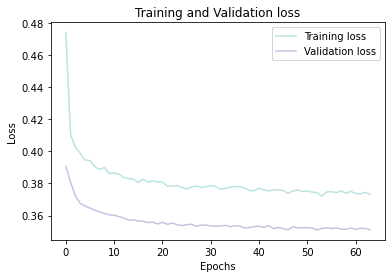

In [ ]:
df_history = pd.DataFrame(model_fitted.history)

plt.plot(df_history.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(df_history.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc="best")

# CONCLUSION

In [ ]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)

<AxesSubplot:>

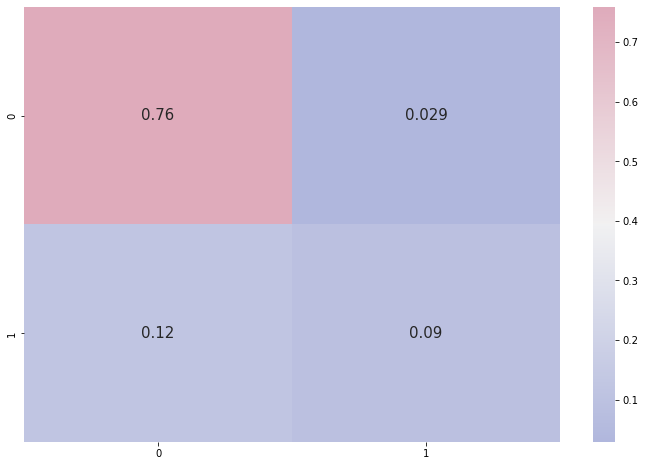

In [ ]:
# confusion matrix

cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)

plt.subplots(figsize=(12,8))

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [ ]:
loss, acc = model.evaluate(x_test,y_test,batch_size=32)
print(loss,acc)

798/798 [==============================] - 0s 564us/step - loss: 0.3480 - accuracy: 0.8486
0.34796142578125 0.848635733127594
